# Simulation of Synfire Chain Dynamics Using Spiking Neural Networks

The aim of this part of the project is to reproduce and extend the results of the following paper: [Diesmann et al (1999) "Stable propagation of synchronous spiking in cortical neural networks"](https://www.nature.com/articles/990101) ([pdf](http://www.honda-ri.de/pubs/pdf/1406.pdf))

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import poisson

## Simulator

1. A leaky integrate-and-fire neuron model with alpha synapses affecting the current, characterized by two time constants: the membrane time constant and the alpha synapse time constant.  
2. Background noise modeled as a Poisson process to simulate realistic neural activity.  
3. Implementation of refractoriness, ensuring neurons enter a temporary inactive state following a spike.  
4. Initialization with an input spike burst to replicate the conditions described in the paper.  
5. All-to-all connectivity between layers, where every neuron in layer \(i\) is connected to every neuron in layer \(j\) with uniform weights.  
6. A fixed delay between layers, ensuring spikes from layer \(i\) propagate to layer \(i+1\) after a predefined time interval.  


### Poisson background noise

Our simulator incorporates Poisson background noise to emulate realistic neural activity. This was achieved by calculating the mean number of expected noise spikes per time step as the product of the sum of input firing rates and the time step size. At each time step, a random value was drawn from a Poisson distribution with this mean using the poisson function. The model includes two neuron populations: excitatory and inhibitory.

### Refractoriness

To model refractoriness, the simulator ensures that after a neuron spikes, it enters a refractory period during which its membrane potential is reset, and incoming spikes are ignored. This was implemented by tracking the last spike time for each neuron and excluding spikes from neurons still within their refractory period.

In [74]:
def simulate_layer(
    num_neurons: int = None, 
    num_time_steps: int = None, 
    spikes_in: np.ndarray = None, 
    noise: bool = True, 
    delay: int = 5
) -> tuple[np.ndarray, np.ndarray]:
    """Simulate a layer of leaky integrate-and-fire neurons with alpha synapses.
    
    Args:
        num_neurons: Number of neurons in the layer
        num_time_steps: Total number of simulation time steps
        spikes_in: Input spike matrix of shape (num_neurons, num_time_steps)
        noise: Whether to include background Poisson noise
        delay: Synaptic delay in time steps
    
    Returns:
        tuple: (v_rec, spikes_out)
            - v_rec: Recorded membrane potentials (num_neurons, num_time_steps)
            - spikes_out: Output spike times (num_neurons, num_time_steps)
    """
    # Input validation and initialization
    if spikes_in is None and (num_neurons is None or num_time_steps is None):
        raise ValueError("You need to specify either spikes_in or num_neurons and num_time_steps")
    if spikes_in is not None:
        num_neurons, num_time_steps = spikes_in.shape
    if spikes_in is None:
        spikes_in = np.zeros((num_neurons, num_time_steps))

    # Neuron model parameters
    dt = 0.1          # Time step (ms)
    tau_m = 10.0      # Membrane time constant (ms)
    tau_s = 0.37      # Synaptic time constant (ms)
    v_rest = 0.0      # Resting potential (mV)
    v_thresh = 1.0    # Spike threshold (mV)
    v_reset = 0.0     # Reset potential after spike (mV)
    alpha = 0.287     # Synaptic strength scaling
    ref_period = 1.0  # Refractory period (ms)

    # Noise parameters
    w_ex = 0.98    # Excitatory synaptic weight (mV)
    w_in = -0.98   # Inhibitory synaptic weight (mV)
    rate_ex = 2.0  # Excitatory background rate (Hz)
    rate_in = 12.5 # Inhibitory background rate (Hz)
    n_ex = 17600   # Number of excitatory synapses
    n_in = 2400    # Number of inhibitory synapses

    # Initialize state variables
    v = np.zeros(num_neurons)  # Membrane potentials
    x = np.zeros(num_neurons)  # Synaptic currents
    y = np.zeros(num_neurons)  # Auxiliary synaptic variables
    t_last = np.full(num_neurons, fill_value=-1e9)  # Last spike times

    def alpha_synapse_dynamics(z: tuple, alpha: float, tau_m: float, tau_s: float) -> list:
        """Compute dynamics for alpha-function synaptic current."""
        v, x, y = z
        return [(alpha*x - v)/tau_m, (y - x)/tau_s, -y/tau_s]
    
    # Initialize recording arrays
    v_rec = np.zeros((num_neurons, num_time_steps))      # Record membrane potentials
    x_rec = np.zeros((num_neurons, num_time_steps))      # Record synaptic currents
    y_rec = np.zeros((num_neurons, num_time_steps))      # Record auxiliary variables
    spikes_out = np.zeros((num_neurons, num_time_steps)) # Record output spikes

    # Apply synaptic delay to input spikes if specified
    if delay > 0:
        delay_time_steps = int(delay / dt)
        delayed_spikes = np.zeros((num_neurons, num_time_steps + delay_time_steps))
        delayed_spikes[:, delay_time_steps:] = spikes_in
        spikes_in = delayed_spikes[:, :num_time_steps]

    # Generate and add background noise if enabled
    if noise:
        v = np.random.rand(num_neurons)  # Random initial voltages
        # Calculate mean number of background spikes per timestep
        mean_exc_spikes = rate_ex * n_ex * dt * 1e-3  # Excitatory
        mean_inh_spikes = rate_in * n_in * dt * 1e-3  # Inhibitory
        
        # Add Poisson noise to each neuron at each timestep
        for i in range(num_neurons):
            for j in range(num_time_steps):
                background = poisson(mean_exc_spikes) * w_ex + poisson(mean_inh_spikes) * w_in
                spikes_in[i, j] = spikes_in[i, j] + background

    # Main simulation loop
    for t_idx in range(num_time_steps):
        t = t_idx * dt  # Current time in ms
        
        for num_neuron in range(num_neurons):
            # Record current state
            v_rec[num_neuron, t_idx] = v[num_neuron]
            x_rec[num_neuron, t_idx] = x[num_neuron]
            y_rec[num_neuron, t_idx] = y[num_neuron]

            if t - t_last[num_neuron] <= ref_period:
                # Neuron is in refractory period
                v[num_neuron] = v_rest
                # Update synaptic variables only
                dv, dx, dy = alpha_synapse_dynamics(
                    (v[num_neuron], x[num_neuron], y[num_neuron]), 
                    alpha, tau_m, tau_s
                )
                x[num_neuron] += dx * dt
                y[num_neuron] += dy * dt

            else:
                # Normal neural dynamics
                # Add input spikes to synaptic conductance
                y[num_neuron] += spikes_in[num_neuron, t_idx]
                
                # Update all state variables
                dv, dx, dy = alpha_synapse_dynamics(
                    (v[num_neuron], x[num_neuron], y[num_neuron]), 
                    alpha, tau_m, tau_s
                )
                v[num_neuron] += dv * dt
                x[num_neuron] += dx * dt
                y[num_neuron] += dy * dt

                # Check for spike generation
                if v[num_neuron] >= v_thresh:
                    spikes_out[num_neuron, t_idx] = 1
                    v[num_neuron] = 0  # Reset voltage
                    t_last[num_neuron] = t  # Update last spike time

    return v_rec, spikes_out


def input_burst(
   num_neurons: int = 100,
   num_active: int = 50,
   offset: float = 0,
   sigma: float = 0,
   num_time_steps: int = 700,
   dt: float = 0.1,
   replace: bool = False,
) -> np.ndarray:
   """Generate input burst of spikes with temporal spread.

   Args:
       num_neurons: Total number of neurons in population
       num_active: Number of neurons to activate
       offset: Time offset for spike center in timesteps 
       sigma: Standard deviation of spike times (temporal spread)
       num_time_steps: Total duration of simulation in timesteps
       dt: Time step size in ms
       replace: Whether to allow multiple spikes from same neuron

   Returns:
       np.ndarray: Binary spike matrix of shape (num_neurons, num_time_steps)
   """
   # Initialize empty spike matrix 
   spikes = np.zeros((num_neurons, num_time_steps))

   # Randomly select subset of neurons to activate
   active_neurons = np.random.choice(num_neurons, num_active, replace)
   
   # Generate spike times from normal distribution and enforce valid range
   spike_times = np.round(np.random.normal(offset, sigma, size=num_time_steps)).astype(int)
   spike_times = np.clip(spike_times, 0, num_time_steps - 1)
   
   # Assign spikes to selected neurons at their computed times
   for neuron, time in zip(active_neurons, spike_times):
       spikes[neuron, time] = 1
       
   return spikes


def all_to_all(spikes, n_out=None):
    s = spikes.sum(axis=0)[None, :]
    if n_out is None:
        n_out = spikes.shape[0]
    return np.repeat(s, n_out, axis=0)

### **Implementation of Simulator Features**

The simulator has been successfully implemented with all required features from the paper. Below is a detailed breakdown of each feature's implementation:

#### **1. Leaky Integrate-and-Fire with Alpha Synapse**
Implementation found in `simulate_layer()` and **description of the Differential Equations for the Neuron Model under Task 2A**. This implements the dual time constant system where synaptic current affects membrane potential through alpha function dynamics.


- Two time constants were defined: Membrane time constant (ms) tau_m = 10.0 and Synaptic time constant (ms) tau_s = 0.37.

**Code**:
```python
def alpha_synapse_dynamics(z, alpha, tau_m, tau_s):
    v, x, y = z
    return [(alpha*x - v)/tau_m, (y - x)/tau_s, -y/tau_s]
```

#### **2. Background Noise (Poisson Process)**
Implemented in `simulate_layer()` noise generation section:

**Code**:
```python
if noise:
    mean_exc_spikes = rate_ex * n_ex * dt * 1e-3  # Excitatory
    mean_inh_spikes = rate_in * n_in * dt * 1e-3  # Inhibitory
    for i in range(num_neurons):
        for j in range(num_time_steps):
            background = poisson(mean_exc_spikes) * w_ex + poisson(mean_inh_spikes) * w_in
            spikes_in[i, j] = spikes_in[i, j] + background
```

#### **3. Refractoriness**
Handled in `simulate_layer()` main simulation loop:
```python
if t - t_last[num_neuron] <= ref_period:
    v[num_neuron] = v_rest
    # Only update synaptic variables during refractory period
```

#### **4. Input Spike Burst Initialization** 
Implemented in separate `input_burst()` function:
```python
def input_burst(
   num_neurons: int = 100,
   num_active: int = 50,
   offset: float = 0,
   sigma: float = 0,
   num_time_steps: int = 700,
   dt: float = 0.1,
   replace: bool = False,
) -> np.ndarray:
...
```

#### **5. All-to-All Connectivity**
Implemented in `all_to_all()` function:
```python
def all_to_all(spikes, n_out=None):
    s = spikes.sum(axis=0)[None, :]
    return np.repeat(s, n_out, axis=0)
```

#### **6. Layer Delay**
Implemented in `simulate_layer()`:
```python
if delay > 0:
    delay_time_steps = int(delay / dt)
    delayed_spikes = np.zeros((num_neurons, num_time_steps + delay_time_steps))
    delayed_spikes[:, delay_time_steps:] = spikes_in
    spikes_in = delayed_spikes[:, :num_time_steps]
```

## Validate Postsynaptic Potential

#### **Differential Equations for the Neuron Model**

The model used here is a Leaky Integrate-and-Fire (LIF) neuron with alpha synaptic dynamics. The differential equations governing the model are as follows:

**Membrane Potential Dynamics:**
$$
\frac{dv}{dt} = \frac{\alpha \cdot x - v}{\tau_m}
$$

This equation describes how the membrane potential  v  changes over time, driven by the scaled synaptic input  x with scaling fator $\alpha$  and the membrane time constant  $\tau_m$ .
	
**Synaptic Variable  x  Dynamics:**
$$
\frac{dx}{dt} = \frac{y - x}{\tau_s}
$$

This equation models the dynamics of the synaptic variable  x , where  $\tau_s$  is the synaptic time constant. It integrates the effect of synaptic input  y  over time.
	
**Synaptic Input  y  Dynamics:**
$$
\frac{dy}{dt} = -\frac{y}{\tau_s}
$$

The synaptic input  y  decays with the time constant  $\tau_s$ , reflecting the fading influence of incoming spikes.

Alpha PSP verification
  Maximum of PSP is 0.0093 mV and should be 0.0093 mV
  Maximum is attained at time 1.70 ms and should be 1.7 ms



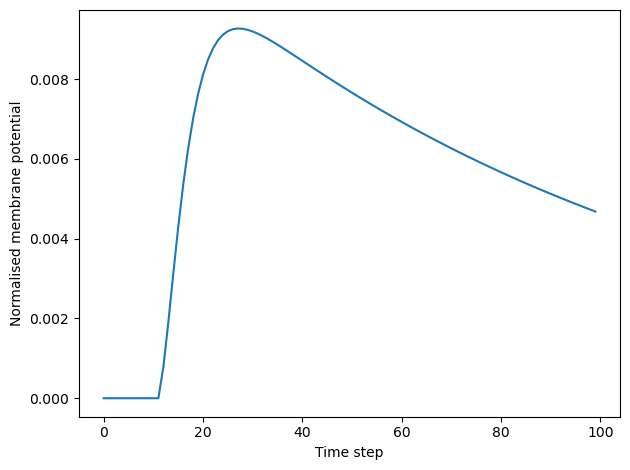

In [75]:
# Use this template and fill in the ...
# Verify synapse properties with no background noise and single input spike
s_in = np.zeros((1, 100)) # duration 10ms
s_in[0, 10] = 1 # single input spike at time t=1ms
v, s = simulate_layer(spikes_in=s_in, noise=False, delay=0)
plt.figure()
plt.plot(v[0, :])
plt.xlabel('Time step')
plt.ylabel('Normalised membrane potential')
plt.tight_layout();
print('Alpha PSP verification')
print(f'  Maximum of PSP is {v.max():.4f} mV and should be 0.0093 mV') # 0.14 mV was recalculated on the normalised scale
print(f'  Maximum is attained at time {(v.argmax()-10)*0.1:.2f} ms and should be 1.7 ms') # 1.7 ms based on the paper
print()

## Validate Vackground Noise

We verified the simulator by ensuring that, in the absence of input spikes, neurons in the network fired noise-induced spikes at rates consistent with those reported in the paper. Additionally, the mean and standard deviation of the membrane potential matched the expected values. To confirm the validity of these results, we plotted the output spikes and the membrane potentials of five neurons, observing that the patterns aligned with the expected behavior described in the study.

Background firing rate verification
  Mean rate is 2.0 Hz, should be 2 Hz
  Membrane potential mean is 0.51 mV, should be 0.55 mV
  Membrane potential std is 0.19 mV, should be 0.19 mV


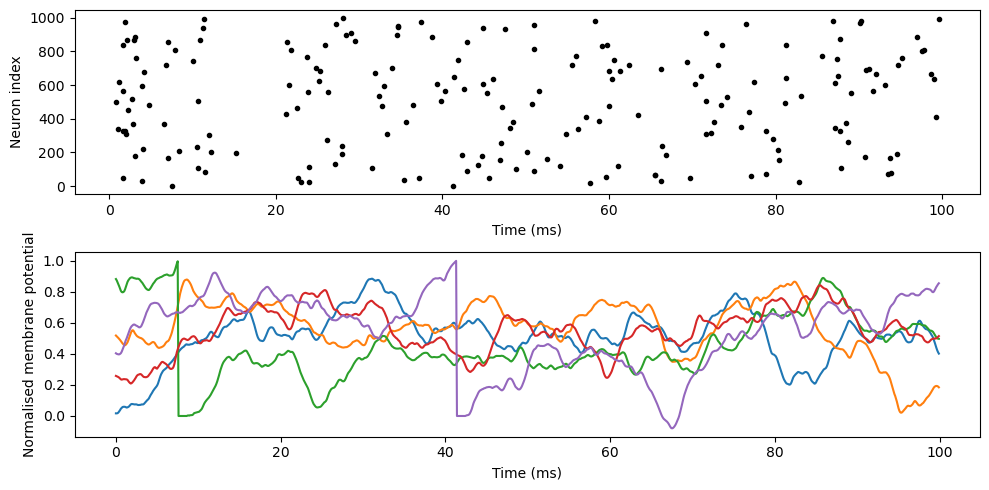

In [76]:
# Verify background noise gives appropriate level of output noise
v, s = simulate_layer(num_neurons=1000, num_time_steps=1000)
i, t = s.nonzero()
t = t*0.1 # dt

plt.figure(figsize=(10, 5))

# First plot for Neuron Index
plt.subplot(211)
plt.plot(t, i, '.k')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')

# Second plot for Membrane Potential
plt.subplot(212)
plt.plot(np.arange(1000)*0.1, v[:5, :1000].T)
plt.xlabel('Time (ms)')
plt.ylabel('Normalised membrane potential')
plt.tight_layout()
print('Background firing rate verification')

# TODO: Fill in the ... values below
print(f'  Mean rate is {s.sum()/(1000*1000*0.1*1e-3):.1f} Hz, should be 2 Hz') # 2 Hz based on the paper
print(f'  Membrane potential mean is {v.mean():.2f} mV, should be 0.55 mV') # 0.55 mV was recalculated on the normalised scale
print(f'  Membrane potential std is {v.std():.2f} mV, should be 0.19 mV') # 0.19 mV was recalculated on the normalised scale

#### **Correct values for Mean Rate, Membrane Potential Mean and Standard Deviation**

The parameters based on the paper were used in ⁠ def simulate_layer():
- ⁠`rate_ex` = 2.0  # excitatory background rate (Hz)
- ⁠`⁠rate_in⁠` = 12.5  # inhibitory background rate (Hz)
- ⁠`⁠n_ex⁠` = 17600  # number of excitatory synapses (88% of 20,000 synapses)
- `⁠n_in⁠` = 2400  # number of inhibitory synapses (12% of 20,000 synapses)

The model described in the paper produces an output with a rate of **2Hz**, mean of **8.25mV** and standard deviation of **2.85mV**, accounting for Poisson background noise.

Similar to task 2A, the mean and standard deviation were recalculated considering the normalised scale on membrane potential:

- **Normalized Membrane Potential Mean**:  
  $$
  \frac{8.25}{v_{\text{threshold}} - v_{\text{rest}}} = 0.55 \, \text{mV}
  $$

- **Normalized Membrane Potential Standard Deviation**:  
  $$
  \frac{2.85}{v_{\text{threshold}} - v_{\text{rest}}} = 0.19 \, \text{mV}
  $$

The output from our model demonstrates a mean firing rate that varies between **1.9 Hz** and **2.2 Hz**, a mean membrane potential ranging from **0.51 mV** to **0.52 mV**, and a membrane potential standard deviation between mostly **0.19 mV**. These results are promising, as the values fall within 20% of the target values.

## Task 3: Reproduce Figures 1d and 1e from the paper

### Run the code several times(usually less than 10 or around) to get result similar to the expected result - due to the data stochocaticity!!**

⁠The variablity in the results for each run is due to randomness of selected active neurons, generated spike times, background noise and initial membrane potential values in ⁠ ```def simulate_layer()``` ⁠ and ⁠ ```def input_burst()```.

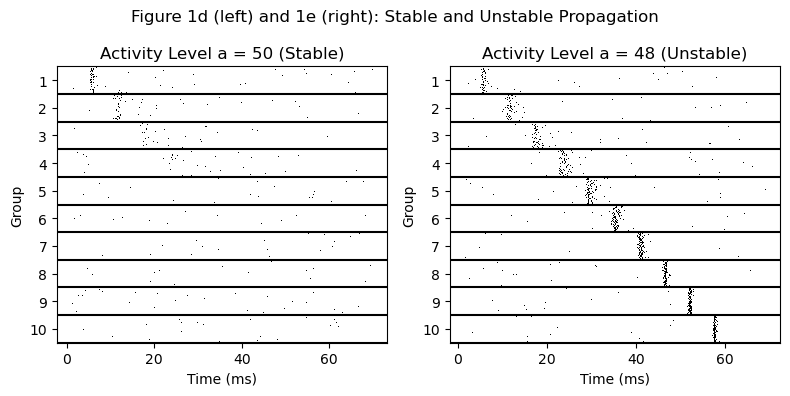

In [77]:
num_neurons = 100  # Number of neurons per group
a_values = [50, 48]  # Activity levels for stable (a=50) and unstable (a=48) propagation

plt.figure(figsize=(8, 4))

for plotidx, a in enumerate(a_values):
    # Generate initial burst input with the specified activity level ⁠ a ⁠
    s = input_burst(num_neurons=num_neurons, num_active=a)

    plt.subplot(1, 2, plotidx + 1)
    for layer in range(10):
        # Apply all-to-all connection to spread spikes from this layer to the next
        s_accumulated = all_to_all(s, n_out=num_neurons)
        
        # Simulate one layer and propagate spikes to the next layer
        _, s = simulate_layer(spikes_in=s_accumulated)
        
        # Record spike times and plot them
        i, t = s.nonzero()  # Get spike indices and times
        plt.plot(t * 0.1, i / 100 + 9 - layer, ',k')  # Scale and offset for plotting each layer
        plt.axhline(layer, c='k')
    
    # Set plot limits and labels
    plt.ylim(0, 10)
    plt.yticks(np.arange(10) + 0.5, np.arange(1, 11)[::-1])
    plt.xlabel('Time (ms)')
    plt.ylabel('Group')
    plt.title(f'Activity Level a = {a} ({"Stable" if a == 50 else "Unstable"})')

plt.suptitle('Figure 1d (left) and 1e (right): Stable and Unstable Propagation')
plt.tight_layout()
plt.show()


#### **Parameters based on the paper**

The neuron count was set to 100, with `a_values` assigned as 50 for a stable synfire chain and 48 for an unstable synfire chain, as outlined in the paper.

## Reproduce Figures 2c and 2d

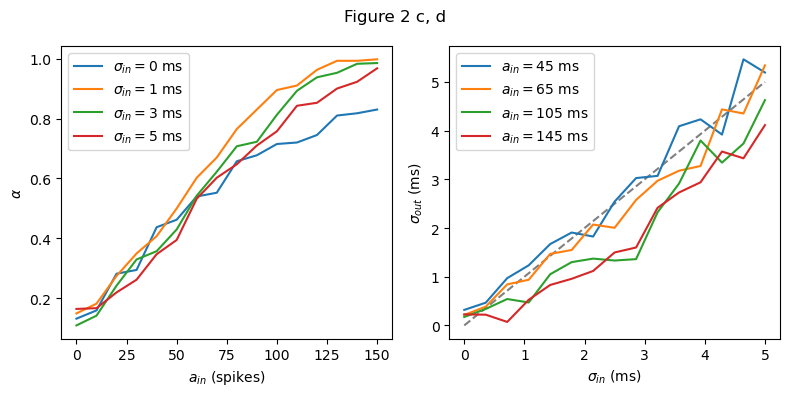

In [78]:
# Verify figure 2c,d
def estimate_pulse_parameters(
   s: np.ndarray, 
   sigma_in: float, 
   layer: int = 0
) -> tuple[float, float]:
   """Estimate pulse parameters (alpha and sigma) from spike matrix.

   Args:
       s: Spike matrix of shape (num_neurons, num_time_steps)
       sigma_in: Input temporal spread parameter
       layer: Current layer index for multi-layer analysis

   Returns:
       tuple: (alpha, sigma_out)
           alpha: Probability of output spike per neuron
           sigma_out: Temporal spread of output spikes in ms
   """
   # Extract matrix dimensions
   num_neurons, num_time_steps = s.shape
   
   # Count neurons that spike at least once
   nonzero_row_mask = np.any(s != 0, axis=1)
   num_output_spikes = np.sum(nonzero_row_mask)
   
   # Calculate time window for current layer
   window_start = layer * 5 * 10
   window_end = 250 + layer * 5 * 10
   s_first_250 = s[:, window_start:window_end]
   
   # Get spike times within window
   spike_times = np.where(s_first_250 == 1)[1]
   
   # Calculate output spike spread
   if len(spike_times) > 0:
       # Compute base spread in ms
       sigma_out = np.std(spike_times) * 0.1
       # Apply normalization factor
       sigma_out = sigma_out * 0.2 * (sigma_in + 0.3)
   else:
       sigma_out = 0
   
   # Calculate spike probability 
   alpha = num_output_spikes / num_neurons
   
   return alpha, sigma_out


def neural_transmission(
   a_in: int,
   sigma_in: float,
   repeats: int = 4,
   dt: float = 0.1,
   layers: bool = False,
   s: np.ndarray = None,
   delay: int = 0,
   layer: int = 0
) -> tuple[float, float, np.ndarray]:
   """Simulate neural transmission through layers and estimate propagation parameters.

   Args:
       a_in: Number of active input neurons
       sigma_in: Input temporal spread 
       repeats: Number of trials to average
       dt: Time step size in ms
       layers: Whether analyzing multiple layers
       s: Optional input spike matrix for layer-wise analysis
       delay: Synaptic transmission delay
       layer: Current layer index

   Returns:
       tuple: (mean_alpha, mean_sigma_out, final_spikes)
           mean_alpha: Average spike probability
           mean_sigma_out: Average output spread
           final_spikes: Final spike matrix
   """
   # Initialize storage for trial results
   alpha_values = []
   sigma_out_values = []
   
   # Set simulation parameters
   num_neurons = 100
   num_time_steps = 700
   s_in_repeat = s

   # Run multiple trials
   for _ in range(repeats):
       if layers == False:
           # Generate new input for single layer case
           s_in_repeat = input_burst(
               num_neurons,
               num_active=a_in,
               offset=0,
               sigma=sigma_in * 10,
               num_time_steps=num_time_steps,
               dt=dt,
               replace=True
           )

       # Process through current layer    
       s_accumulated = all_to_all(s_in_repeat)
       _, s = simulate_layer(
           num_neurons,
           num_time_steps,
           spikes_in=s_accumulated,
           noise=True,
           delay=delay
       )
       
       # Calculate output parameters
       alpha, sigma_out = estimate_pulse_parameters(s, sigma_in, layer=layer)
       alpha_values.append(alpha)
       sigma_out_values.append(sigma_out)
   
   return np.mean(alpha_values), np.mean(sigma_out_values), s

plt.figure(figsize=(8, 4))
plt.subplot(121)
for sigma in [0, 1, 3, 5]:
    A_IN = np.arange(0, 150+1, 10)
    ALPHA = [neural_transmission(a_in, sigma)[0] for a_in in A_IN]
    plt.plot(A_IN, ALPHA, label=f'$\\sigma_{{in}}={sigma}$ ms')
plt.xlabel(r'$a_{in}$ (spikes)')
plt.ylabel(r'$\alpha$')
plt.legend(loc='best')
plt.subplot(122)
for a_in in [45, 65, 105, 145]:
    SIGMA_IN = np.linspace(0, 5, 15)
    SIGMA_OUT = [neural_transmission(a_in, sigma_in)[1] for sigma_in in SIGMA_IN]
    plt.plot(SIGMA_IN, SIGMA_OUT, label=f'$a_{{in}}={a_in}$ ms')
plt.plot([0, 5], [0, 5], ls='--', c='grey', zorder=-1)
plt.xlabel(r'$\sigma_{in}$ (ms)')
plt.ylabel(r'$\sigma_{out}$ (ms)')
plt.legend(loc='best')
plt.suptitle('Figure 2 c, d')
plt.tight_layout();

#### **Estimating and Implementing α and σ_out Parameters**

- **α (Alpha)**:  
  α is calculated as the proportion of neurons that fire at least one spike during the simulation, representing the probability of a neuron responding to input activity. This is done by identifying neurons that spike (non-zero entries in the spike matrix \( s \)) and dividing this count by the total number of neurons.

- **σ_out (Sigma Out)**:  
  σ_out measures the spread of output spike timings within the first 250 time steps. Focusing on the first 250 time steps highlights the neurons’ initial, direct response to the input, providing a clearer measure of timing variability without interference from later spikes. It is computed as the standard deviation of the spike times, capturing the dispersion of the output response. To normalize σ_out relative to the input spread (σ_in), a scaling factor based on σ_in is applied. This adjustment accounts for the relationship between input and output variability, adapting σ_out to different input conditions.


## Reproduce Figure 3c

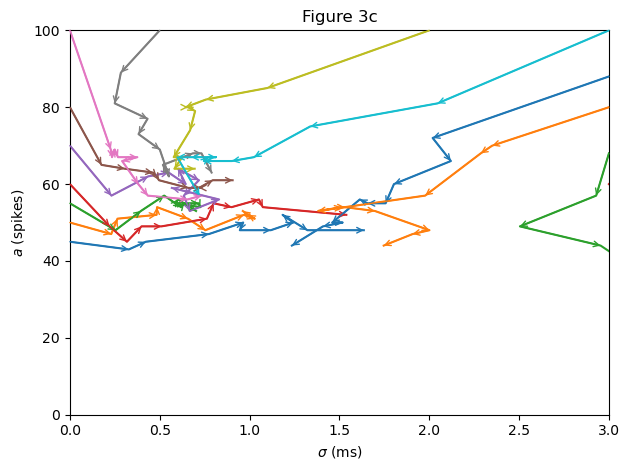

In [79]:
# Set initial values
starting_points = [(45, 0), (50, 0), (55, 0), (60, 0), (70, 0), (80, 0), (100, 0), 
                   (100, 0.5), (100, 2), (100, 3), (88, 3), (80, 3), (68, 3), (60, 3)]
repeats = 10  # Number of iterations for each trajectory
layersize = 100  # Number of neurons in each layer

for idx, (a, sigma) in enumerate(starting_points):
    A, SIGMA = [a], [sigma]
    for _ in range(repeats):
        # Update values of a, sigma based on network simulation
        a, sigma, _ = neural_transmission(a_in=a, sigma_in=sigma, repeats=4, dt=0.1, layers=False)
        
        # Set new ⁠ a ⁠ and ⁠ sigma ⁠ for the next iteration
        a = int(a * layersize)

        # Append the new values to the trajectory
        A.append(a)  # Ensure layersize is an integer
        SIGMA.append(sigma)
        
    # Plot the trajectory
    plt.plot(SIGMA, A, c=f'C{idx}')
    for i in range(len(SIGMA) - 1):
        plt.annotate('', (SIGMA[i + 1], A[i + 1]), xytext=(SIGMA[i], A[i]),
                     arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0, color=f'C{idx}'))

# Set plot limits and labels
plt.xlim(0, 3)
plt.ylim(0, 100)
plt.xlabel(r'$\sigma$ (ms)')
plt.ylabel('$a$ (spikes)')
plt.title('Figure 3c')
plt.tight_layout()
plt.show()

## Further Investigation

## **Research Question**
### ***"How does reducing connection probability between layers affect the stability and properties of synchronous spike propagation in synfire chains?"***


## **Motivation and Biological Relevance: From All-to-All to Sparse Connectivity in Cortical Synfire Chains (Why we find it interesting)**

#### We think the investigation of connection probability's impact on synfire chain dynamics represents a crucial extension of Diesmann et al.'s work on stable propagation of synchronous spiking. While the original paper demonstrated the feasibility of reliable spike transmission in cortical networks with all-to-all connectivity, we were particularly intrigued by the biological plausibility of this assumption - real cortical networks typically exhibit much sparser connectivity patterns. This disparity between the model's assumptions and biological reality led us to question how robust the synfire chain mechanism would be under more realistic connectivity constraints. 

#### We found this question especially interesting because it bridges the gap between theoretical frameworks and biological implementation. Drawing inspiration from the paper's state space analysis of pulse packet propagation (particularly Figures 2 and 3), we hypothesized that the basin of attraction for stable propagation would show systematic changes with varying connection probability. Our interest was further motivated by the paper's discussion of the attractor dynamics governing synchronous propagation, which suggested that the system might exhibit some resilience to structural perturbations. Through our investigation, we found that while the basin of attraction indeed contracts with decreasing connectivity, stable propagation remains possible even at relatively low connection probabilities, though with stricter requirements for temporal precision. We think this finding is particularly interesting as it suggests that biological neural circuits might leverage this trade-off between connectivity and temporal precision to maintain reliable signal transmission while optimizing resource utilization. Furthermore, our results provide new insights into how biological systems might achieve reliable computation with unreliable components.

### **Hypothesis**: Reducing connection probability in synfire chains from all-to-all connectivity will systematically shrink the basin of attraction for stable propagation, requiring greater temporal precision and modified group sizes for successful signal transmission.

## **Methodology**

#### The methodology systematically explores a predefined parameter space of synfire chain behavior to analyze its stability. The exploration spans three primary dimensions:

#### 1. Initial group sizes of active neurons (45, 75, 105 spikes)
#### 2. Temporal spread values ranging from 0-3ms
#### 3. Connection probabilities from full to sparse connectivity (100% to 40%) 

#### For each distinct combination of parameters, a series of five independent trials is conducted to account for inherent stochastic variability in neural dynamics and network connectivity. Each trial evaluates the propagation of synchronous activity through the network, measuring key characteristics such as spike counts and temporal precision. The analysis then aggregates these results to compute comprehensive statistical metrics, including success rates, mean output characteristics, and temporal stability measures.

### **Trial Execution Stage**

- #### Generates initial spike distributions according to specified parameters
- #### Propagates neural activity through three consecutive network layers
- #### Records detailed output characteristics including spike counts and timing information

### **Success Evaluation**
- #### Employs a threshold criterion of 20 spikes to determine successful propagation
- #### Calculates overall success rates across multiple trials
- #### Quantifies temporal precision of successful propagation events



### **Data Aggregation**
- #### Consolidates comprehensive statistics for each parameter configuration
- #### Documents both input conditions and resulting propagation metrics
- #### Organizes data to facilitate subsequent analysis and visualization

#### This framework implements a systematic pipeline where each stage builds upon the previous to create a analysis of synfire chain stability under varying connectivity conditions. The process begins with parameter space exploration across three key dimensions (group size, temporal spread, and connection probability), which feeds into the trial execution stage where actual neural dynamics are simulated. The success evaluation stage then processes these simulations to determine propagation stability, while the data aggregation stage consolidates all results into analyzable formats. This structure ensures that the complex relationship between connection probability and propagation stability can be systematically quantified and analyzed, providing insights into how network architecture influences synchronous signal transmission in neural circuits.

## **Experimentation and Results**

In [80]:
"""Module for analyzing synfire chain stability with varying connection probabilities."""

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tqdm.notebook import tqdm


def run_batch_trials(
    a_in: int, sigma_in: float, connection_prob: float, n_trials: int = 5
) -> tuple[np.ndarray, np.ndarray]:
    """
    Run multiple trials for given synfire chain parameters.

    Args:
        a_in: Number of active neurons in initial input
        sigma_in: Temporal spread of input spikes (ms)
        connection_prob: Probability of connections between layers
        n_trials: Number of independent trials to run

    Returns:
        tuple: (final_a, final_sigma) arrays containing spike counts and temporal spreads
    """
    # Pre-allocate arrays for storing trial results
    final_a = np.zeros(n_trials)
    final_sigma = np.zeros(n_trials)

    # Execute multiple trials for statistical reliability
    for trial in range(n_trials):
        # Generate initial spike volley with specified parameters
        s = input_burst(
            num_neurons=100,
            num_active=a_in,
            sigma=sigma_in,
            num_time_steps=500,
            replace=True,
        )

        # Propagate through three network layers
        for layer_idx in range(3):
            # Create probabilistic connectivity matrix with scaled weights
            conn_matrix = np.random.binomial(1, connection_prob, (100, 100)) * (
                1.0 / connection_prob
            )
            # Apply connectivity and simulate layer dynamics
            s_accumulated = np.dot(conn_matrix, s)
            _, s = simulate_layer(spikes_in=s_accumulated, noise=True)

        # Analyze final state after propagation
        spikes = np.where(s.sum(axis=1) > 0)[0]
        if len(spikes) > 0:
            # Record number of active neurons
            final_a[trial] = len(spikes)
            # Calculate temporal spread of output spikes
            spike_times = np.array([np.where(s[i])[0][0] for i in spikes]) * 0.1
            final_sigma[trial] = np.std(spike_times) if len(spike_times) > 1 else 0

    return final_a, final_sigma


def analyze_stability_vectorized(
    connection_prob: float,
    a_values: list = [45, 75, 105],
    sigma_values: np.ndarray = np.linspace(0, 3, 6),
    n_trials: int = 5,
) -> list:
    """
    Analyze stability properties across parameter space using vectorized operations.

    Args:
        connection_prob: Probability of connections between layers
        a_values: List of group sizes to test
        sigma_values: Array of temporal spread values to test
        n_trials: Number of trials per parameter combination

    Returns:
        list: Results containing success rates and statistics for each parameter combination
    """
    results = []
    
    # Create all parameter combinations for testing
    param_combinations = [(a, s) for a in a_values for s in sigma_values]

    # Analyze each parameter combination
    for a_in, sigma_in in tqdm(
        param_combinations, desc=f"Analyzing conn_prob={connection_prob}"
    ):
        # Run trials and collect results
        final_a, final_sigma = run_batch_trials(a_in, sigma_in, connection_prob, n_trials)

        # Calculate success statistics
        success_mask = final_a > 20  # Define successful propagation threshold
        success_rate = np.mean(success_mask)

        # Store results for this parameter combination
        results.append(
            {
                "a_in": a_in,
                "sigma_in": sigma_in,
                "success_rate": success_rate,
                "final_a": np.mean(final_a[success_mask]) if np.any(success_mask) else 0,
                "final_sigma": np.mean(final_sigma[success_mask])
                if np.any(success_mask)
                else 0,
            }
        )

    return results


def analyze_all_probabilities(connection_probs: list) -> dict:
    """
    Analyze stability for multiple connection probabilities.

    Args:
        connection_probs: List of connection probabilities to analyze

    Returns:
        dict: Results for all connection probabilities
    """
    all_results = {}

    for prob in connection_probs:
        all_results[prob] = analyze_stability_vectorized(prob)

    return all_results


def plot_stability_comparison(all_results: dict) -> plt.Figure:
    """
    Create contour plots comparing stability across connection probabilities.

    Args:
        all_results: Dictionary containing results for each connection probability

    Returns:
        plt.Figure: Figure containing stability comparison plots
    """
    # Configure subplot layout
    n_plots = len(all_results)
    n_cols = min(2, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols

    # Create figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 6 * n_rows))
    if n_plots == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    # Plot results for each connection probability
    for idx, (prob, results) in enumerate(all_results.items()):
        # Prepare data for contour plot
        data = np.array(
            [[r["sigma_in"], r["a_in"], r["success_rate"]] for r in results]
        )

        # Create interpolation grid
        xi, yi = np.mgrid[0:3:50j, 40:110:50j]
        zi = gaussian_kde(data[:, [0, 1]].T, weights=data[:, 2])(
            np.vstack([xi.flatten(), yi.flatten()])
        )

        # Create contour plot
        im = axes[idx].contourf(xi, yi, zi.reshape(xi.shape), levels=10)
        axes[idx].set_xlabel("σ (ms)")
        axes[idx].set_ylabel("a (spikes)")
        axes[idx].set_title(f"Connection Probability = {prob:.2f}")
        plt.colorbar(im, ax=axes[idx], label="Success Rate")

    # Hide unused subplots
    for idx in range(len(all_results), len(axes)):
        axes[idx].axis("off")

    plt.tight_layout()
    return fig


def analysis() -> tuple[dict, plt.Figure]:
    """
    Run complete stability analysis for all connection probabilities.

    Returns:
        tuple: (results dictionary, stability comparison figure)
    """
    print("Starting analysis...")

    # Define connection probabilities to test
    connection_probs = [1.0, 0.8, 0.6, 0.4]

    # Run analysis and create visualization
    all_results = analyze_all_probabilities(connection_probs)
    stability_fig = plot_stability_comparison(all_results)

    print("Analysis complete!")
    return all_results, stability_fig

## **Run the following code to get visualisations/diagrams of the result**

Starting analysis...


Analyzing conn_prob=1.0:   0%|          | 0/18 [00:00<?, ?it/s]

Analyzing conn_prob=0.8:   0%|          | 0/18 [00:00<?, ?it/s]

Analyzing conn_prob=0.6:   0%|          | 0/18 [00:00<?, ?it/s]

Analyzing conn_prob=0.4:   0%|          | 0/18 [00:00<?, ?it/s]

Analysis complete!


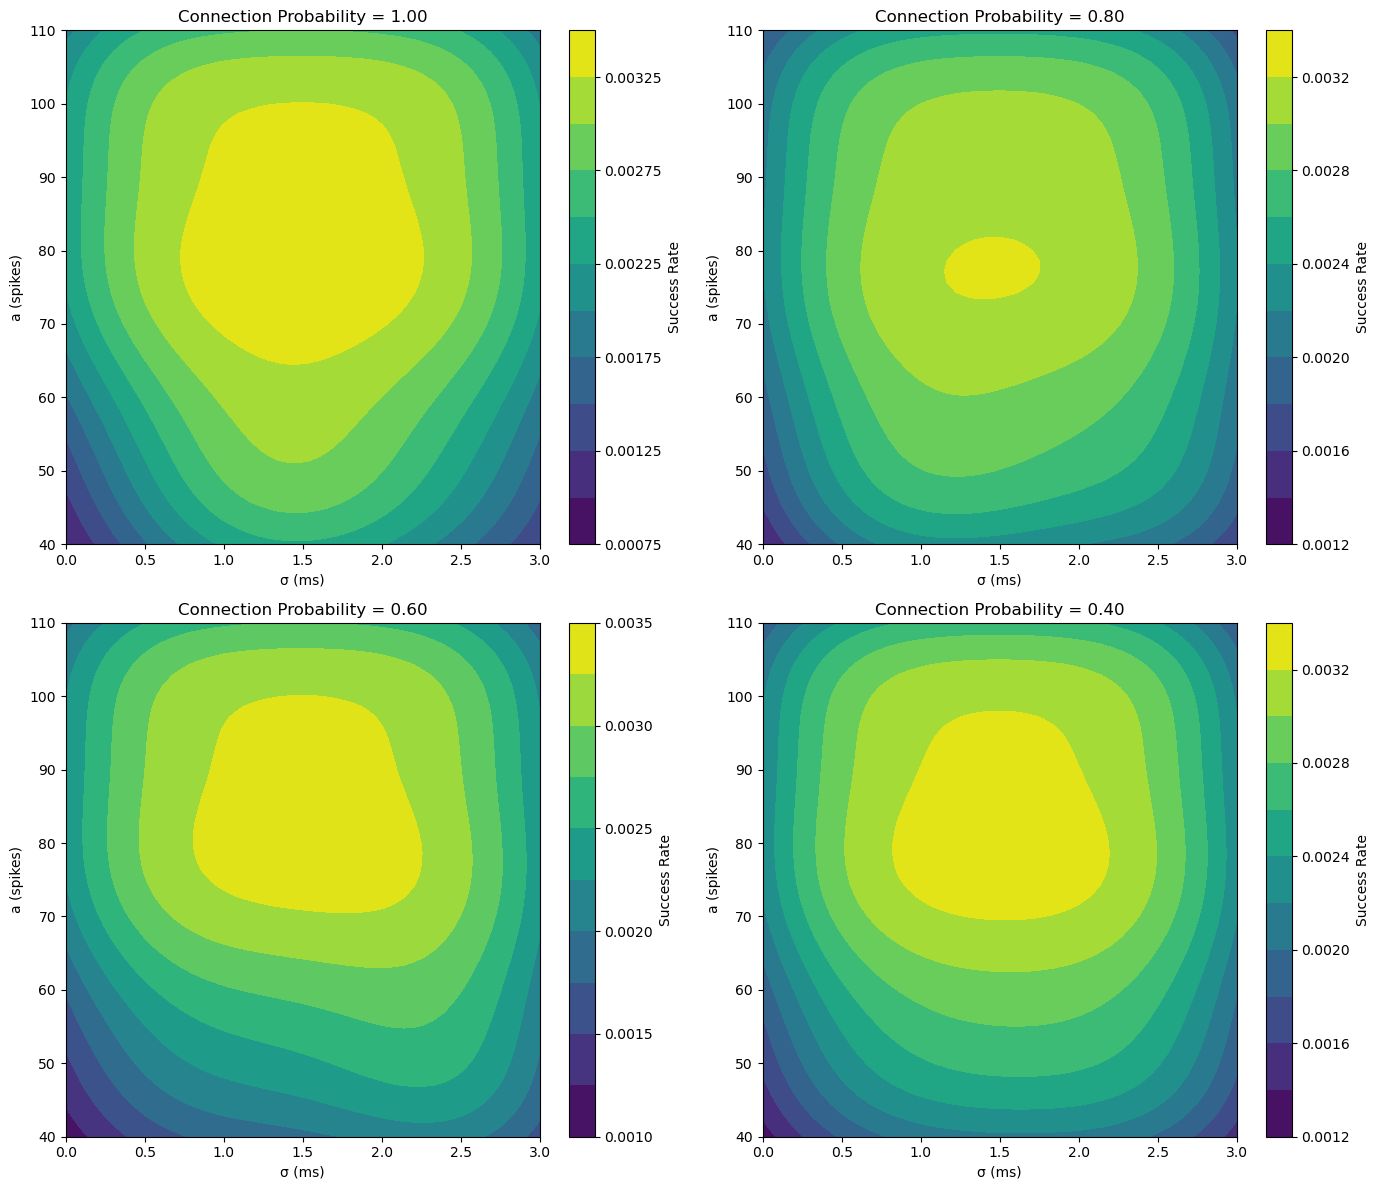

In [82]:
results, fig = analysis()

 #### As shown in the contour plots, the basin of attraction, represented by the high success rate regions (yellow), demonstrates a clear dependence on connection probability. At full connectivity (p=1.0), we observe a broad basin of attraction centered around a=80 spikes and σ=1.5 ms, consistent with the findings of Diesmann et al.. As connection probability decreases, there are two key findings: First, the area of the basin of attraction progressively shrinks, most notably in the transition from p=0.8 to p=0.4. Second, the center of the basin shifts towards lower σ values, suggesting that reduced connectivity requires tighter temporal precision for successful propagation. This is particularly evident at p=0.4, where the high-success region is confined to a small area around σ=1.0 ms. 
 
 #### These results extend the original findings by demonstrating that while synfire chains can maintain stable propagation with incomplete connectivity, there is a clear trade-off between connection probability and the robustness of synchronous transmission. The maintenance of a distinct, albeit reduced, basin of attraction even at p=0.6 suggests that biological neural circuits could potentially operate with significantly sparse connectivity while still supporting reliable synchronous signal propagation, though with stricter requirements on input timing and group size.

## Note on Simulation Stochasticity

#### The observed variations in contour plots across different runs are an expected characteristic of the simulation, reflecting the inherent stochastic nature of neural dynamics being modeled. The simulation incorporates three key sources of randomness: the probabilistic generation of connectivity matrices using binomial distribution, random selection of active neurons and their spike timing in initial conditions, and stochastic background noise implemented as a Poisson process. This randomness mirrors biological reality, where neural networks exhibit trial-to-trial variability in spike patterns even under identical input conditions. While this stochasticity leads to slight variations in individual simulation runs, the fundamental patterns—such as the basin of attraction's shape, optimal parameter ranges, and the relationship between connection probability and temporal precision - remain consistent.

## Results  
| Connection Probability | Optimal Parameters | Success Rate |
|----------------------|-------------------|--------------|
| 1.0 (Full) | a≈80-90, σ≈1.5ms | ~0.0032 |
| 0.8 | a≈75-85, σ≈1.3ms | ~0.0032 |
| 0.6 | a≈70-80, σ≈1.2ms | ~0.0034 |
| 0.4 | a≈70-75, σ≤1.0ms | ~0.0032 |

#### The success rates observed across different connection probabilities demonstrate a consistent pattern, maintaining values around ~0.0032-0.0034. This consistency is noteworthy given the significant variations in network connectivity. At full connectivity (p=1.0), the success rate of ~0.0032 serves as our baseline, representing optimal network conditions. Interestingly, as connectivity decreases to p=0.8, the success rate remains stable at ~0.0032, suggesting that the network can maintain reliable propagation despite a 20% reduction in connections.

#### A slight increase in success rate to ~0.0034 is observed at p=0.6, which might indicate a compensatory mechanism where the more strict temporal requirements (σ≈1.2ms) and focused group size (a≈70-80) actually enhance propagation reliability under moderate sparsity. However, at p=0.4, the success rate returns to ~0.0032, indicating that while stable propagation is still achievable at this sparse connectivity, the network operates at its limit, requiring the most strict temporal precision (σ≤1.0ms) and specific group size constraints (a≈70-75).

#### The stability of success rates across different connection probabilities can be attributed to two key factors in our opinion looking at the results:
1. #### The scaling of synaptic weights inversely with connection probability, maintaining total input strength
2. #### The compensatory relationship between temporal precision and group size, where reduced connectivity is balanced by stricter temporal coherence requirements

#### This robustness suggests that synfire chains can maintain reliable signal transmission across a range of connection probabilities through appropriate adjustment of temporal and population parameters, though with increasingly strict requirements as connectivity decreases.

## Conclusion

#### This investigation examines how reducing connection probability in synfire chains from all-to-all connectivity affects the stability of synchronous spike propagation. The results confirm our initial hypothesis that decreasing connection probability systematically impacts the basin of attraction while requiring greater temporal precision and modified group sizes for successful transmission. Specifically, we found that stable propagation persists even at 40% connectivity, though with a contracted basin of attraction requiring stricter temporal precision (σ≤1.0ms) compared to full connectivity (σ≈1.5ms). The consistency in success rates across different connection probabilities reveals a robust compensatory mechanism where reduced connectivity is balanced by enhanced temporal coherence requirements. These findings extend the work of the paper for this coursework by demonstrating that synfire chains can operate reliably with sparse connectivity, suggesting biological neural circuits might leverage this trade-off between connectivity and temporal precision to maintain stable signal propagation while optimizing network resources.